# Testing Frequency dependent model 

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import FrequencyDependentModel
from Model.back_prop_utils import H_th_function, round_to_sig_figs, c, torch_unwrap
from Model.plotting_utils import plot_transfer, plot_comparison, plot_training_progress
from Model.loss_functions import loss, complex_transfer_loss, complex_real_imag_loss, log_complex_loss

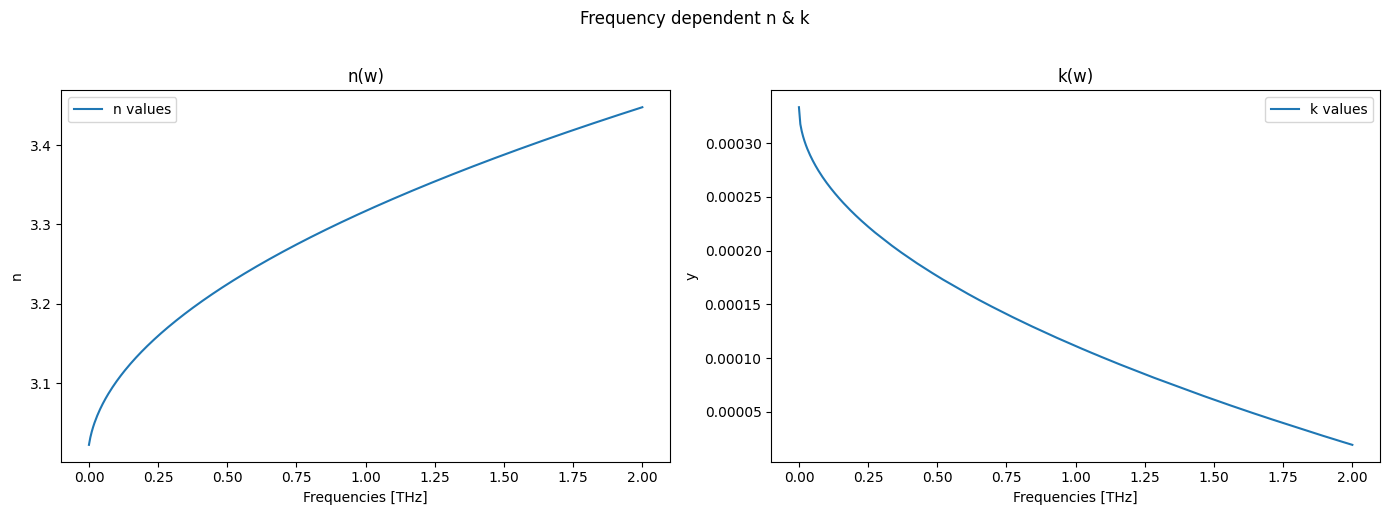

In [2]:
thickness = 3 * 1e-3
# Setup frequency arrays
frequency_bounds = [0.3, 2]
full_w_THz = np.linspace(0,frequency_bounds[1], 400)
full_w_THz = torch.tensor(full_w_THz, dtype=torch.float32)

# Convert to angular freqs for calcs
full_w = full_w_THz * 2 * np.pi * 1e12

n = np.sqrt(0.1 * (full_w_THz + 0.005)) + 3
k = ((np.sqrt(0.000004 * full_w_THz) + 3)**-1) - 0.333

# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.lineplot(x=full_w_THz, y=n, label="n values", ax=ax1)
ax1.set_title('n(w)')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')
ax1.set_ylabel('n')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=full_w_THz, y=k, label="k values", ax=ax2)
ax2.set_title('k(w)')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')
ax2.set_ylabel('y')

# Adjust layout and add main title if needed
plt.suptitle('Frequency dependent n & k', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()

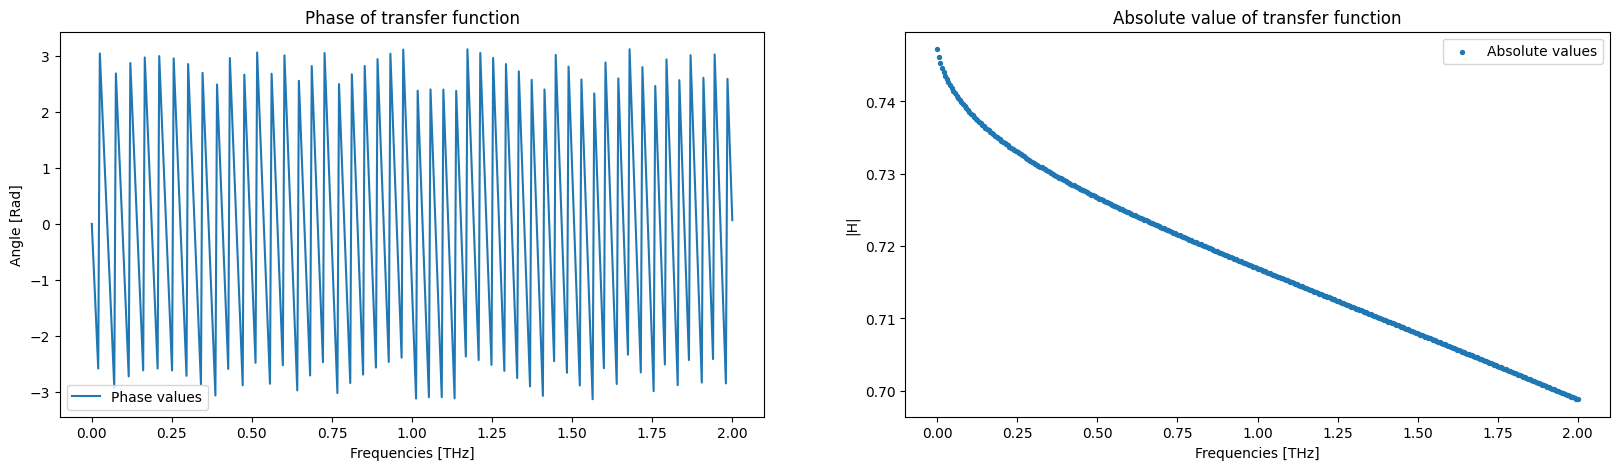

In [3]:
n_complex = n + 1j*k

freq_dep_H = H_th_function(n_complex, w=full_w, length=thickness)

# Break down into components
freq_dep_H_abs = torch.abs(freq_dep_H)
freq_dep_H_phase = torch.angle(freq_dep_H)

plot_transfer(full_w_THz, absolute_values=freq_dep_H_abs, phase_values=freq_dep_H_phase)

Epoch 0: Loss = 5.818089008331299
Epoch 500: Loss = 0.1828453689813614
Epoch 1000: Loss = 0.06379958242177963
Epoch 1500: Loss = 0.028247317299246788
Epoch 2000: Loss = 0.013171006925404072
Epoch 2500: Loss = 0.00592953572049737
Epoch 3000: Loss = 0.002401200123131275
Epoch 3500: Loss = 0.000806250493042171
Epoch 4000: Loss = 0.0002050032198894769
Epoch 4500: Loss = 3.664796895463951e-05
Epoch 5000: Loss = 4.3226496018178295e-06
Epoch 5500: Loss = 1.5020863202153123e-06
Epoch 6000: Loss = 2.560929260653211e-06
Epoch 6500: Loss = 9.950603043762385e-07
Epoch 7000: Loss = 7.882273393988726e-07
Epoch 7500: Loss = 1.1866399063364952e-06
Epoch 8000: Loss = 1.0227764732917421e-06
Epoch 8500: Loss = 1.413477434653032e-06
Epoch 9000: Loss = 1.1541719686647411e-06
Epoch 9500: Loss = 2.36802907238598e-06


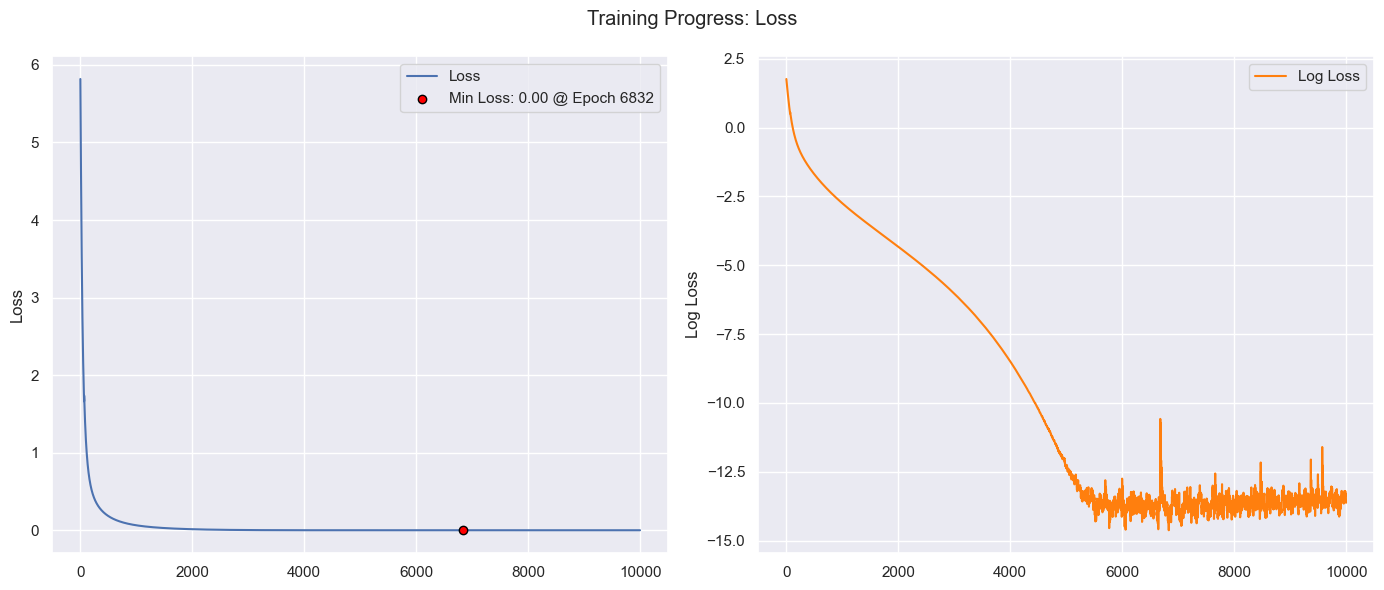

In [4]:
freq_model = FrequencyDependentModel(w_tensor=full_w, d=thickness, ICs_n=3.2, ICs_k=0.0001)

# Setup Optimizer and scheduler
optimizer_freq = torch.optim.Adam(freq_model.parameters(), lr=5e-4)

# Not used at the moment
scheduler_freq = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer_freq, mode='min', factor=0.1, patience=250)


freq_model.train_model(H_exp=freq_dep_H, Physical_model=H_th_function, loss_fn=log_complex_loss, epochs=10000, optimizer=optimizer_freq)
plot_training_progress(freq_model.loss_history)

In [9]:
n_w = freq_model.n.detach().cpu().numpy()
k_w = freq_model.k.detach().cpu().numpy()

frequencies = full_w_THz


def plot_material_params(frequencies, n, k):
    # Create the first subplot (assuming 'data1' is your first dataset)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # First plot: Approximate values of n from NR solution
    sns.scatterplot(x=frequencies, y=n, label="n values", ax=ax1)
    ax1.set_title('Approximate values of n')
    ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax1.set_xlabel('Frequencies [THz]')

    # Second plot (assuming 'data2' is your second dataset with x and y values)
    sns.scatterplot(x=frequencies, y=k, label="k values", ax=ax2)
    ax2.set_title('Approximate values of k')
    ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax2.set_xlabel('Frequencies [THz]')

    # Adjust layout and add main title if needed
    plt.suptitle('Material Parameters', y=1.02)
    plt.tight_layout()
    plt.legend()
    plt.show()


def compare_material_params(frequencies, n1, k1, n2, k2):
    # Create the first subplot (assuming 'data1' is your first dataset)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # First plot: Approximate values of n from NR solution
    sns.scatterplot(x=frequencies, y=n1, label="n1 values", ax=ax1)
    sns.scatterplot(x=frequencies, y=n2, label="n2 values", ax=ax1)
    ax1.set_title('Approximate values of n')
    ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax1.set_xlabel('Frequencies [THz]')


    sns.scatterplot(x=frequencies, y=k1, label="k1 values", ax=ax2)
    sns.scatterplot(x=frequencies, y=k2, label="k2 values", ax=ax2)
    ax2.set_title('Approximate values of k')
    ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax2.set_xlabel('Frequencies [THz]')

    # Adjust layout and add main title if needed
    plt.suptitle('Comparison of Material Parameters', y=1.02)
    plt.tight_layout()
    plt.legend()
    plt.show()


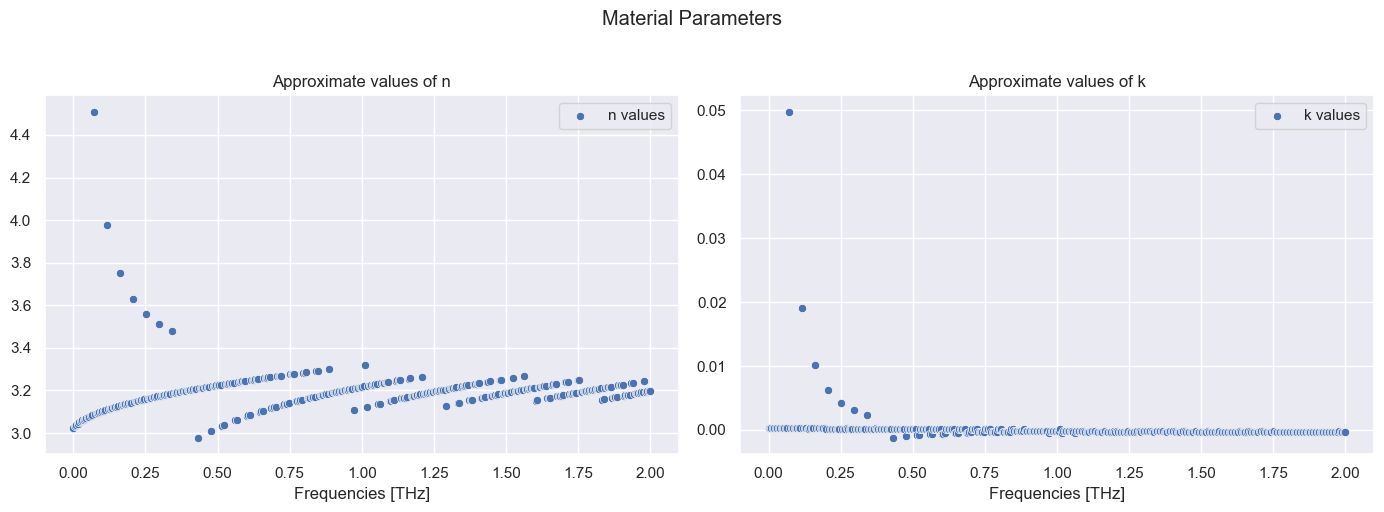

In [6]:
plot_material_params(frequencies=frequencies, n=n_w, k=k_w)

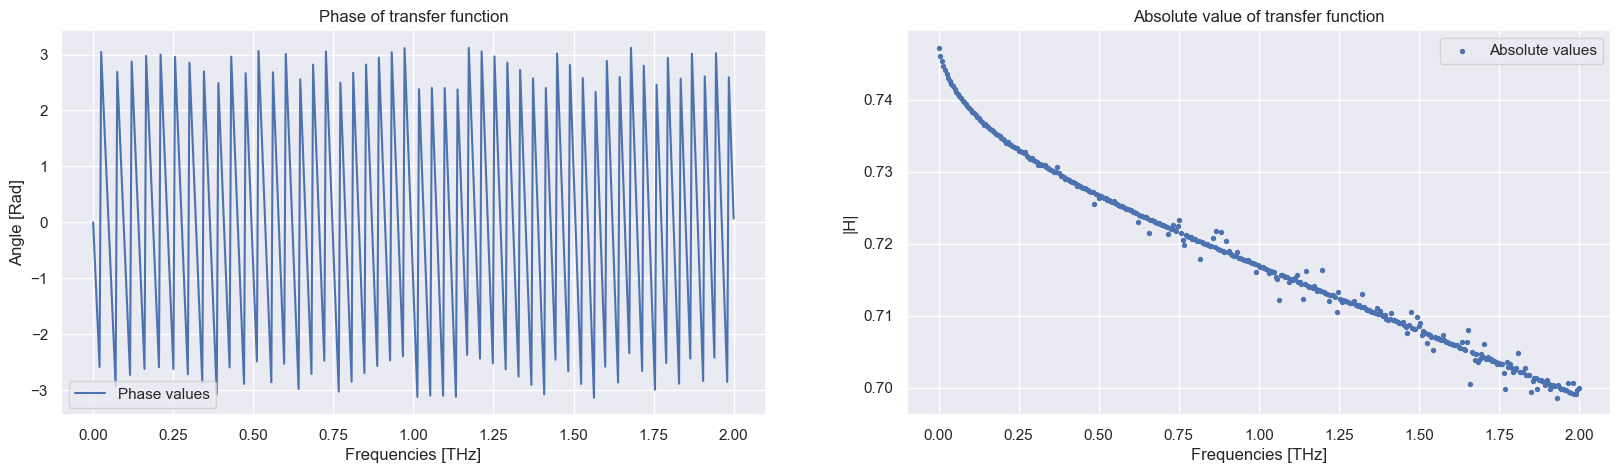

In [7]:
n_complex_w = n_w + 1j*k_w
n_complex_w = torch.tensor(n_complex_w, dtype=torch.cfloat)

H_w_recon = H_th_function(n_complex=n_complex_w, w=full_w, length=thickness)

H_w_recon_abs = torch.abs(H_w_recon)
H_w_recon_phase = torch.angle(H_w_recon)

plot_transfer(frequencies, H_w_recon_abs, H_w_recon_phase)

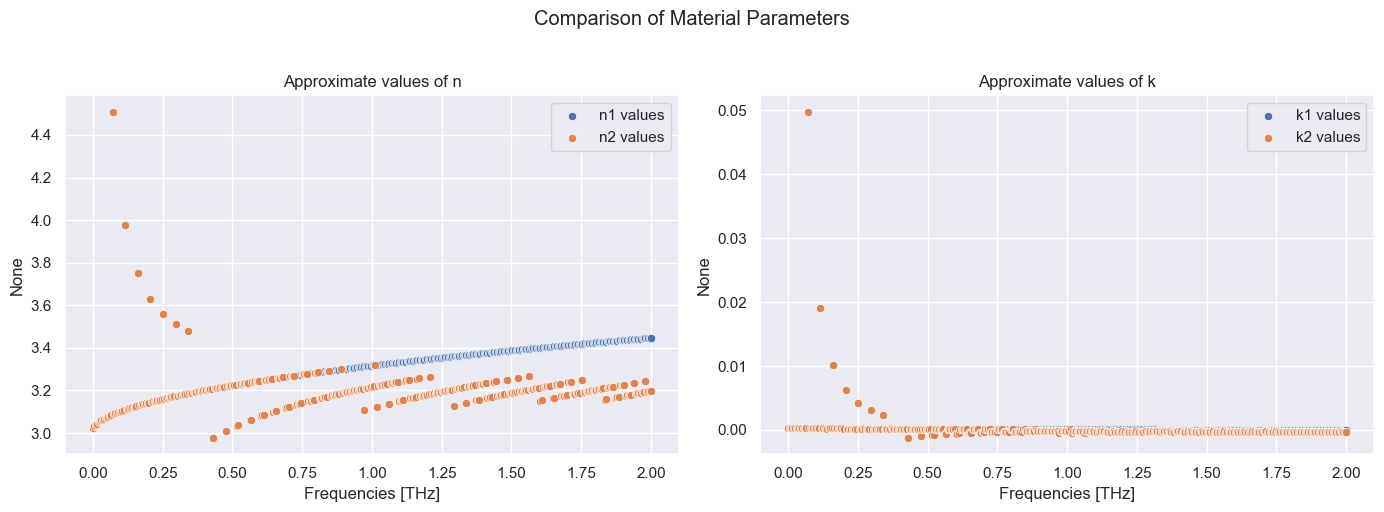

In [10]:
compare_material_params(frequencies=frequencies, n1=n, k1=k, n2=n_w, k2=k_w)

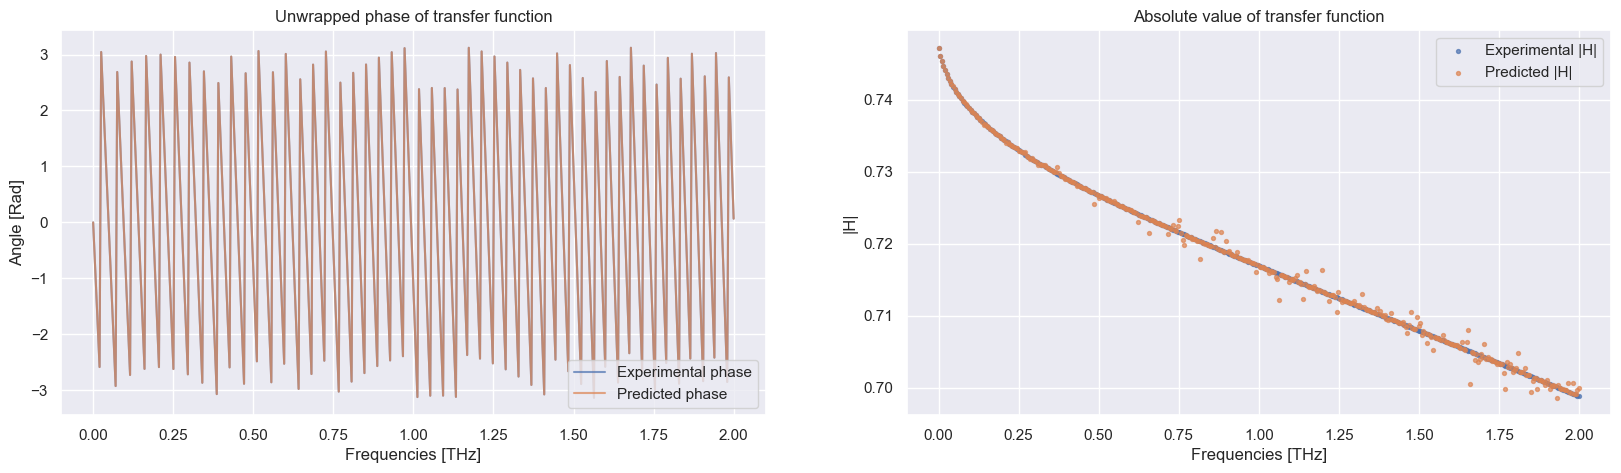

In [8]:
plot_comparison(frequencies=frequencies, exp_abs=freq_dep_H_abs, exp_phase=freq_dep_H_phase, pred_abs=H_w_recon_abs, pred_phase=H_w_recon_phase)

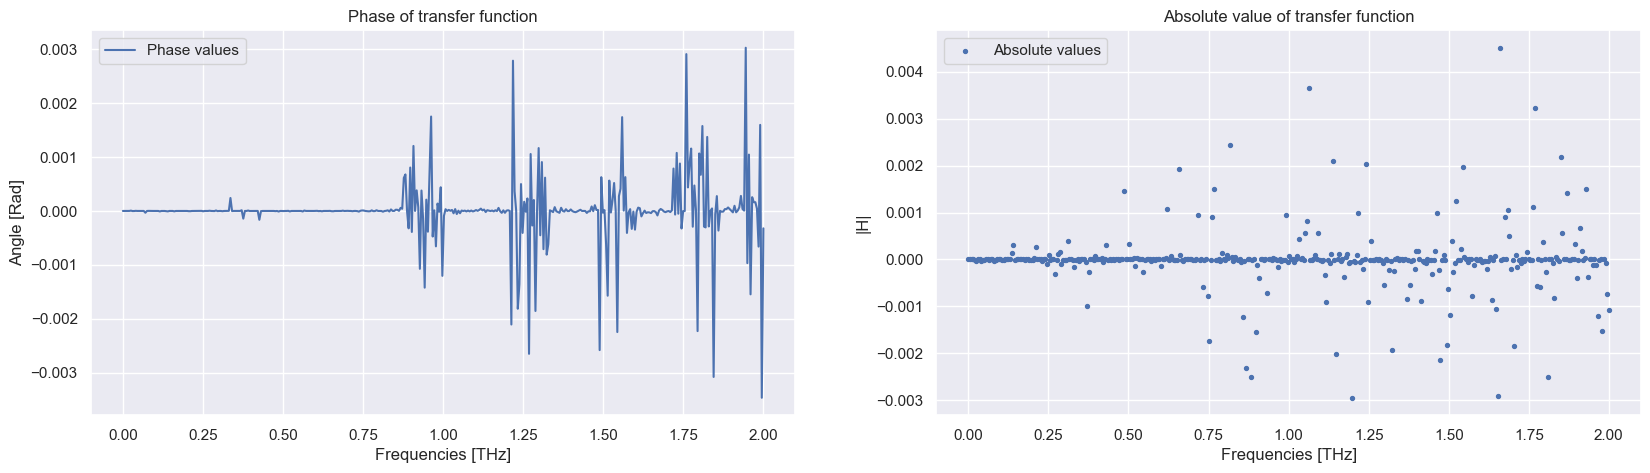

In [14]:
# Plot the errors at each frequency point

delta_phase = freq_dep_H_phase - H_w_recon_phase
delta_abs = freq_dep_H_abs - H_w_recon_abs

plot_transfer(frequencies=frequencies, absolute_values=delta_abs, phase_values=delta_phase)